In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt

import cryojax.simulator as cxs
from cryojax.constants import (
    get_tabulated_scattering_factor_parameters,
    read_peng_element_scattering_factor_parameter_table,
)
from cryojax.io import read_atoms_from_pdb


jax.config.update("jax_enable_x64", True)


atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    "./data/5w0s.pdb",
    center=True,
    select="not element H",
    loads_b_factors=True,
)
scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
    atom_identities, read_peng_element_scattering_factor_parameter_table()
)
atom_potential = cxs.PengAtomicPotential(
    atom_positions,
    scattering_factor_a=scattering_factor_parameters["a"],
    scattering_factor_b=scattering_factor_parameters["b"],
    b_factors=b_factors,
)

instrument_config = cxs.InstrumentConfig(
    shape=(111, 111),
    pixel_size=2.0,
    voltage_in_kilovolts=100.0,
)

real_voxel_grid = atom_potential.as_real_voxel_grid(
    (111, 111, 111), instrument_config.pixel_size
)
voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, instrument_config.pixel_size, pad_scale=1.5
)

/home/michael/miniforge3/envs/cryojax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=6.0,
    offset_y_in_angstroms=-7.0,
    theta_angle=90.0,
    psi_angle=20.0,
    phi_angle=0.0,
)
structural_ensemble = cxs.SingleStructureEnsemble(voxel_potential, pose)

ctf = cxs.AberratedAstigmaticCTF(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)

In [ ]:
transfer_theory = cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1)

scattering_theory_wo_ewald = cxe.HighEnergyScatteringTheory(
    structural_ensemble,
    cxe.EwaldSphereExtraction(),
    cxe.WaveTransferTheory(ctf),
    amplitude_contrast_ratio=0.1,
)
scattering_theory_w_ewald = cxs.WeakPhaseScatteringTheory(
    structural_ensemble,
    cxe.EwaldSphereExtraction(),
    cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1),
)

In [4]:
image_model_wo_ewald = cxs.ContrastImageModel(
    instrument_config, scattering_theory_wo_ewald
)
image_model_w_ewald = cxs.ContrastImageModel(instrument_config, scattering_theory_w_ewald)

key = jax.random.key(0)
im_wo_ewald, im_w_ewald = (
    image_model_wo_ewald.render(key),
    image_model_w_ewald.render(key),
)

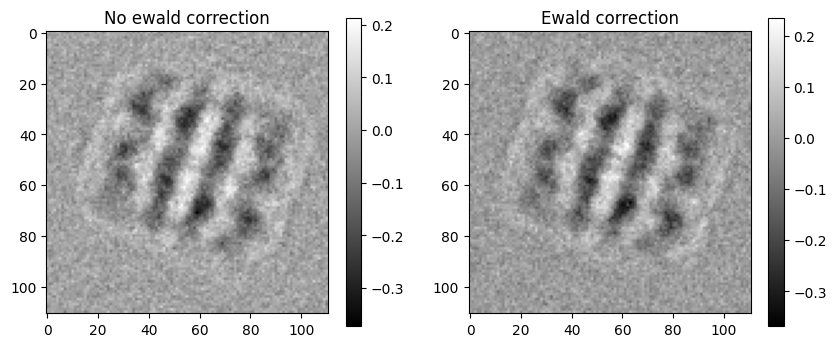

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
m1 = axes[0].imshow(im_wo_ewald, cmap="gray")
m2 = axes[1].imshow(im_w_ewald, cmap="gray")
axes[0].set(title="No ewald correction")
axes[1].set(title="Ewald correction")
fig.colorbar(m1)
fig.colorbar(m2)

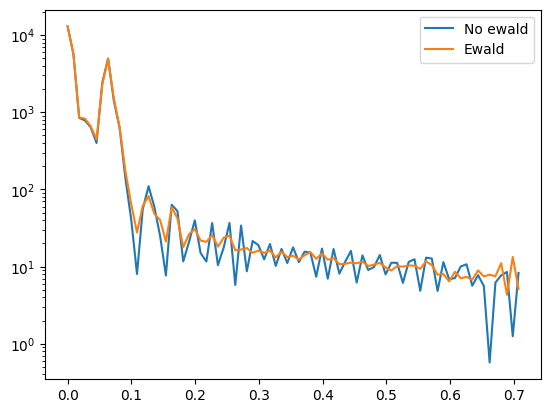

In [6]:
from cryojax.image import compute_binned_powerspectrum, rfftn


radial_frequency_grid = jnp.linalg.norm(
    instrument_config.frequency_grid_in_pixels, axis=-1
)
spectrum_wo_ewald, bins = compute_binned_powerspectrum(
    rfftn(im_wo_ewald), radial_frequency_grid
)
spectrum_w_ewald, bins = compute_binned_powerspectrum(
    rfftn(im_w_ewald), radial_frequency_grid
)

plt.plot(bins, spectrum_wo_ewald, label="No ewald")
plt.plot(bins, spectrum_w_ewald, label="Ewald")
plt.legend()
plt.yscale("log")